# VAE Model Implementation 



In [1]:
%matplotlib inline
import time
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
seed = 6969
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  6969


In [2]:
import torch
import torchvision.datasets  as dsets
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

import tqdm
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, FileLink

In [3]:
import tqdm
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, FileLink

In [4]:
# Connect Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Root directory for dataset
dataroot = "drive/MyDrive/extracted2/"

# Directory to store generated fake images
fake_image_save_path = 'drive/MyDrive/extracted2/vae/'

# Data Normalization Setting
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# Resize Images to same dimension to facilitate Evaluation
from genericpath import isdir
from PIL import Image
import os, sys

raw_data_path = dataroot + 'images/'
processed_data_path = "drive/MyDrive/extracted2/Processed1/images/"
raw_images = os.listdir(raw_data_path) # This line intermittently causes failure due to huge number of Files. Retry multiple times and it will eventually pass.
#print('Number of Raw Images in Input Data:',len(raw_images))
if not os.path.isdir(processed_data_path):
  os.makedirs(processed_data_path)
processed_images = set(os.listdir(processed_data_path))
print('Number of Pre-processed Images in Input Data:',len(processed_images))
# COMMENT NOTE: Instead of deleting them, we're instead going to skip processing them
# elif len(os.listdir(raw_data_path))!=len(os.listdir(processed_data_path)):
#   # Delete all Processed Files if some are missing
#   for root, dirs, files in os.walk(processed_data_path, topdown=False):
#     for file in files:
#         os.remove(os.path.join(root, file))
#     for dir in dirs:
#         os.rmdir(os.path.join(root, dir))

# If all files already exist, do not run it again
if len(raw_images)!=len(processed_images):
  image_index = 0
  for image in raw_images:
    image_path = os.path.join(raw_data_path, image)
    image_save_path = os.path.join(processed_data_path, image)
    if len(image.split("."))<2 or (image.split(".")[1] not in ["jpg", "png"]) or (image in processed_images):
        continue
    if os.path.exists(image_path):
        try:
          im = Image.open(image_path)
          image_resized = im.resize((image_size,image_size))
          image_resized.save(image_save_path, quality=100)
        except:
          print(f'Failed: {image}')
    if image_index%500==0:
      print(f'Processed {image_index} images')
    image_index+=1
  print('Images Resized and Saved')

Number of Pre-processed Images in Input Data: 0
Processed 0 images
Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images
Processed 8500 images
Processed 9000 images
Processed 9500 images
Processed 10000 images
Processed 10500 images
Processed 11000 images
Processed 11500 images
Processed 12000 images
Processed 12500 images
Processed 13000 images
Processed 13500 images
Processed 14000 images
Processed 14500 images
Processed 15000 images
Processed 15500 images
Processed 16000 images
Processed 16500 images
Processed 17000 images
Processed 17500 images
Processed 18000 images
Processed 18500 images
Processed 19000 images
Processed 19500 images
Processed 20000 images
Processed 20500 images
Processed 

In [6]:
# UnNormalize Class allows us to reverse the data processing, get the original image tensor back to write to a file

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=normalize_mean, std=normalize_std)

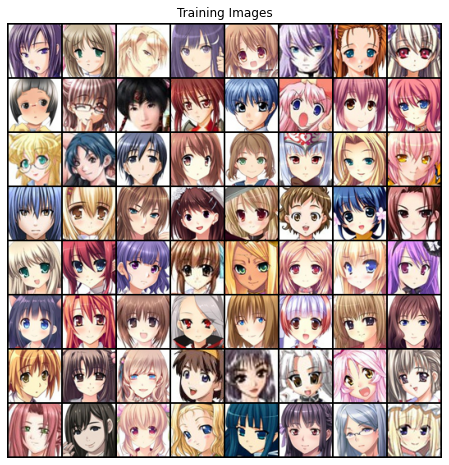

In [10]:
# Create the dataset [Intermittently fails because of large number of Files. Retry until it succeeds.]
dataroot = '/content/drive/MyDrive/Processed_15KSubset/' # TEMP
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(normalize_mean, normalize_std),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)


In [12]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [13]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),
                                 x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [14]:
model = VAE()
try:
    model.load_state_dict(torch.load('vae.pth'))
except:
    print("Weights not found ):")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Weights not found ):


**Model for 1 Epoch**

In [15]:
n1=time.perf_counter()
for epoch in range(1):
    train_loss = 0   
    n3=time.perf_counter() 
    for data, _ in tqdm.tqdm(dataloader):
      try:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
      except:
        pass    
    n4=time.perf_counter()
    print( 'epoch---', epoch ,"---" , n4-n3)
    
        
    torch.save(model.state_dict(), "vae.pth")
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

model.eval()
n2=time.perf_counter()
print(n2-n1)
FileLink(r'vae.pth')

100%|██████████| 118/118 [03:42<00:00,  1.89s/it]

epoch--- 0 --- 222.8413954439999
epoch 0, loss -46958.8788
222.88904833399988


/content/vae.pth

In [16]:
def get(x):
    return dataset[x][0].view(1, 3, image_size, image_size)

def imshow(img):
    pic = np.transpose(img.numpy(), (1,2,0))
    plt.axis('off')
    return plt.imshow(pic, animated=True)

def morph(inputs, steps: int, delay: int):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data[0]
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

In [17]:
fake_image_save_path = '/content/drive/MyDrive/extracted/img/'

In [48]:
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
print(" ----for 1 epochs without normalization------")

 ----for 1 epochs without normalization------


 ----for 10 epochs------


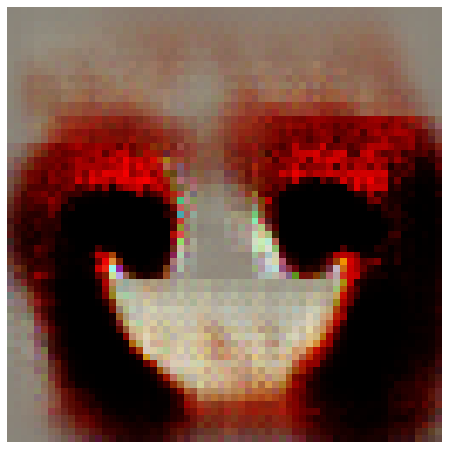

In [18]:

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[1], padding=2).cpu(),(1,2,0)))

In [19]:
fake_images = decoded_batch # img_list[-1]
print(len(fake_images))
for i in range(len(fake_images)):
  save_image(unorm(fake_images[i]), fake_image_save_path+f'fake_image_{i}.jpeg')

128


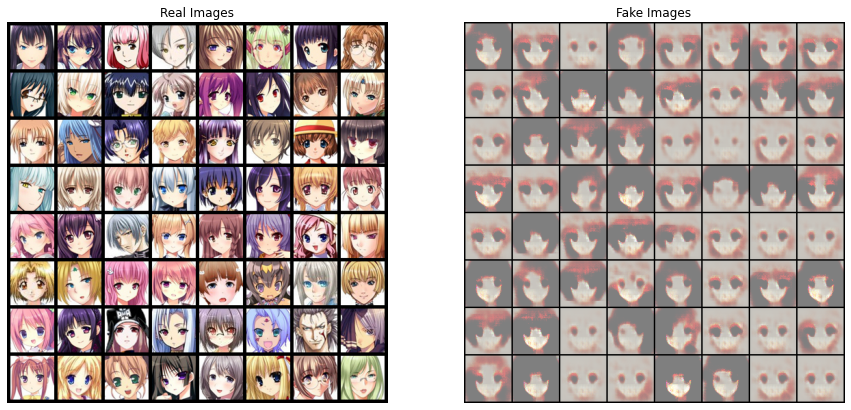

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[:64], padding=2).cpu(),(1,2,0)))
plt.show()

**Batch Normalization Added**

In [22]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [23]:
n1=time.perf_counter()
for epoch in range(1):
    train_loss = 0   
    n3=time.perf_counter() 
    for data, _ in tqdm.tqdm(dataloader):
      try:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
      except:
        pass    
    n4=time.perf_counter()
    print( 'epoch---', epoch ,"---" , n4-n3)
    
        
    torch.save(model.state_dict(), "vae.pth")
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

model.eval()
n2=time.perf_counter()
print(n2-n1)
FileLink(r'vae.pth')

100%|██████████| 118/118 [03:33<00:00,  1.81s/it]

epoch--- 0 --- 213.183001547
epoch 0, loss -81106.8838
213.26125717500008


/content/vae.pth

In [47]:
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
print(" ----for 1 epoch normalized------")

 ----for 1 epoch normalized------


 ----for 20 epochs------


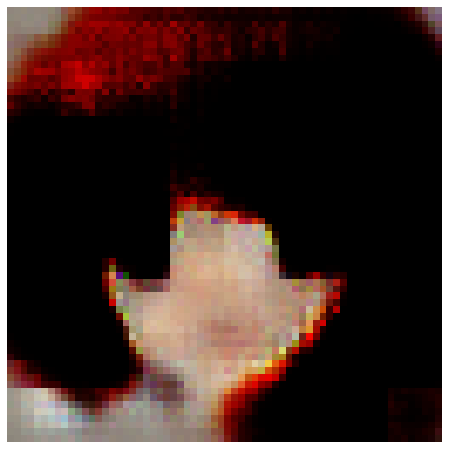

In [24]:

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[1], padding=2).cpu(),(1,2,0)))

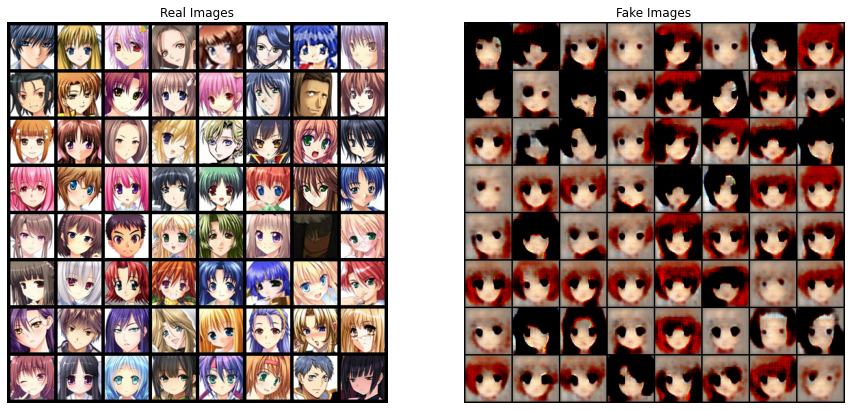

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[:64], padding=2).cpu(),(1,2,0)))
plt.show()

In [28]:
fake_images = decoded_batch # img_list[-1]
print(len(fake_images))
for i in range(len(fake_images)):
  save_image(unorm(fake_images[i]), fake_image_save_path+f'fake_image_{i}.jpeg')

128


In [27]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

**Without Normalizations**

In [29]:
n1=time.perf_counter()
for epoch in range(50):
    train_loss = 0   
    n3=time.perf_counter() 
    for data, _ in tqdm.tqdm(dataloader):
      try:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
      except:
        pass    
    n4=time.perf_counter()
    print( 'epoch---', epoch ,"---" , n4-n3)
    
        
    torch.save(model.state_dict(), "vae.pth")
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

model.eval()
n2=time.perf_counter()
print(n2-n1)
FileLink(r'vae.pth')

100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 0 --- 201.54770054799974
epoch 0, loss -98784.8985


100%|██████████| 118/118 [03:24<00:00,  1.73s/it]


epoch--- 1 --- 204.14109331600048
epoch 1, loss -107438.2952


100%|██████████| 118/118 [03:28<00:00,  1.77s/it]


epoch--- 2 --- 208.50653318200057
epoch 2, loss -112488.9459


100%|██████████| 118/118 [03:28<00:00,  1.77s/it]


epoch--- 3 --- 208.89529584199954
epoch 3, loss -116216.5906


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 4 --- 202.7644813119996
epoch 4, loss -119079.0622


100%|██████████| 118/118 [03:32<00:00,  1.80s/it]


epoch--- 5 --- 212.62527746700016
epoch 5, loss -121497.5167


100%|██████████| 118/118 [03:30<00:00,  1.78s/it]


epoch--- 6 --- 210.13966263200018
epoch 6, loss -123467.7680


100%|██████████| 118/118 [03:28<00:00,  1.77s/it]


epoch--- 7 --- 208.91811926799983
epoch 7, loss -125031.4205


100%|██████████| 118/118 [03:37<00:00,  1.84s/it]


epoch--- 8 --- 217.4057389970003
epoch 8, loss -126412.8262


100%|██████████| 118/118 [03:31<00:00,  1.79s/it]


epoch--- 9 --- 211.6186780979997
epoch 9, loss -127581.8141


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 10 --- 202.9976537399998
epoch 10, loss -128494.1849


  2%|▏         | 2/118 [00:04<04:31,  2.34s/it]


FileNotFoundError: ignored

 ----for 10 epochs------


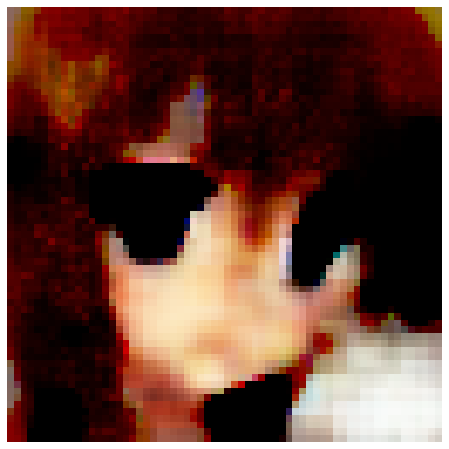

In [45]:
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
print(" ----for 10 epochs------")
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[9], padding=2).cpu(),(1,2,0)))

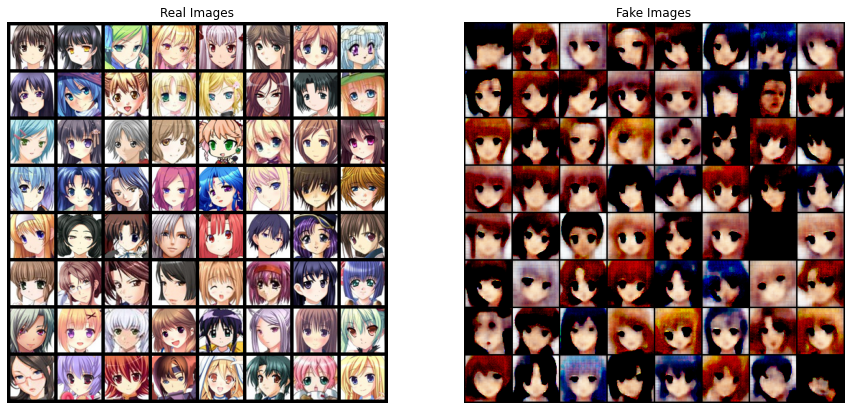

In [31]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[:64], padding=2).cpu(),(1,2,0)))
plt.show()

In [33]:
fake_images = decoded_batch # img_list[-1]
print(len(fake_images))
for i in range(len(fake_images)):
  save_image(unorm(fake_images[i]), fake_image_save_path+f'fake_image_{i}.jpeg')

128


**50 Epochs**

In [34]:
n1=time.perf_counter()
for epoch in range(50):
    train_loss = 0   
    n3=time.perf_counter() 
    for data, _ in tqdm.tqdm(dataloader):
      try:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
      except:
        pass    
    n4=time.perf_counter()
    print( 'epoch---', epoch ,"---" , n4-n3)
    
        
    torch.save(model.state_dict(), "vae.pth")
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

model.eval()
n2=time.perf_counter()
print(n2-n1)
FileLink(r'vae.pth')

100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 0 --- 201.61867802899997
epoch 0, loss -129496.5074


100%|██████████| 118/118 [03:18<00:00,  1.68s/it]


epoch--- 1 --- 198.59164692600007
epoch 1, loss -130314.7521


100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 2 --- 201.7833910119998
epoch 2, loss -130930.0119


100%|██████████| 118/118 [03:19<00:00,  1.69s/it]


epoch--- 3 --- 199.31441337900014
epoch 3, loss -131721.4495


100%|██████████| 118/118 [03:18<00:00,  1.69s/it]


epoch--- 4 --- 198.99522964000062
epoch 4, loss -132199.0205


100%|██████████| 118/118 [03:18<00:00,  1.69s/it]


epoch--- 5 --- 198.98322387000007
epoch 5, loss -132873.3049


100%|██████████| 118/118 [03:19<00:00,  1.69s/it]


epoch--- 6 --- 199.20744068299973
epoch 6, loss -133355.6398


100%|██████████| 118/118 [03:16<00:00,  1.67s/it]


epoch--- 7 --- 196.87543315699986
epoch 7, loss -133836.4488


100%|██████████| 118/118 [03:24<00:00,  1.73s/it]


epoch--- 8 --- 204.05563392599834
epoch 8, loss -134336.4908


100%|██████████| 118/118 [03:23<00:00,  1.73s/it]


epoch--- 9 --- 203.5821350340011
epoch 9, loss -134701.8962


100%|██████████| 118/118 [03:20<00:00,  1.70s/it]


epoch--- 10 --- 200.71614984500047
epoch 10, loss -135180.8551


100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 11 --- 201.31456572000025
epoch 11, loss -135626.9442


100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 12 --- 201.9787460059997
epoch 12, loss -136000.5056


100%|██████████| 118/118 [03:23<00:00,  1.72s/it]


epoch--- 13 --- 203.47153167100078
epoch 13, loss -136247.6624


100%|██████████| 118/118 [03:19<00:00,  1.69s/it]


epoch--- 14 --- 199.9118619539986
epoch 14, loss -136696.3439


100%|██████████| 118/118 [03:23<00:00,  1.72s/it]


epoch--- 15 --- 203.25650152800154
epoch 15, loss -136938.2942


100%|██████████| 118/118 [03:24<00:00,  1.73s/it]


epoch--- 16 --- 204.74142243200004
epoch 16, loss -137289.8108


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 17 --- 202.51370934399893
epoch 17, loss -137570.7153


100%|██████████| 118/118 [03:25<00:00,  1.75s/it]


epoch--- 18 --- 205.94236640999952
epoch 18, loss -137902.4230


100%|██████████| 118/118 [03:30<00:00,  1.78s/it]


epoch--- 19 --- 210.28707836399917
epoch 19, loss -138260.0734


100%|██████████| 118/118 [03:27<00:00,  1.76s/it]


epoch--- 20 --- 207.8370283109998
epoch 20, loss -138371.3326


100%|██████████| 118/118 [03:30<00:00,  1.78s/it]


epoch--- 21 --- 210.37861282199992
epoch 21, loss -138675.4674


100%|██████████| 118/118 [03:25<00:00,  1.74s/it]


epoch--- 22 --- 205.33048727099958
epoch 22, loss -138953.2592


100%|██████████| 118/118 [03:24<00:00,  1.73s/it]


epoch--- 23 --- 204.6647263319992
epoch 23, loss -139180.0951


100%|██████████| 118/118 [03:25<00:00,  1.74s/it]


epoch--- 24 --- 205.8420942520006
epoch 24, loss -139420.4003


100%|██████████| 118/118 [03:27<00:00,  1.76s/it]


epoch--- 25 --- 207.83301994400063
epoch 25, loss -139632.5553


100%|██████████| 118/118 [03:38<00:00,  1.86s/it]


epoch--- 26 --- 218.9741689679995
epoch 26, loss -139812.9882


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 27 --- 202.84998040199935
epoch 27, loss -140088.5334


100%|██████████| 118/118 [03:25<00:00,  1.75s/it]


epoch--- 28 --- 205.9658787870012
epoch 28, loss -140257.4204


100%|██████████| 118/118 [03:22<00:00,  1.71s/it]


epoch--- 29 --- 202.29414419599925
epoch 29, loss -140385.8821


100%|██████████| 118/118 [03:22<00:00,  1.71s/it]


epoch--- 30 --- 202.151516594
epoch 30, loss -140540.5430


100%|██████████| 118/118 [03:30<00:00,  1.78s/it]


epoch--- 31 --- 210.24604388400076
epoch 31, loss -140762.1397


100%|██████████| 118/118 [03:28<00:00,  1.77s/it]


epoch--- 32 --- 208.406830214999
epoch 32, loss -140932.6804


100%|██████████| 118/118 [03:25<00:00,  1.74s/it]


epoch--- 33 --- 205.51803995999944
epoch 33, loss -141104.8693


100%|██████████| 118/118 [03:26<00:00,  1.75s/it]


epoch--- 34 --- 206.47142935100055
epoch 34, loss -141351.9049


100%|██████████| 118/118 [03:29<00:00,  1.77s/it]


epoch--- 35 --- 209.2702822480005
epoch 35, loss -141508.5816


100%|██████████| 118/118 [03:29<00:00,  1.77s/it]


epoch--- 36 --- 209.24187156400149
epoch 36, loss -141648.4226


100%|██████████| 118/118 [03:24<00:00,  1.73s/it]


epoch--- 37 --- 204.47946759000115
epoch 37, loss -141674.0065


100%|██████████| 118/118 [03:19<00:00,  1.69s/it]


epoch--- 38 --- 199.28593265499876
epoch 38, loss -141837.9675


100%|██████████| 118/118 [03:19<00:00,  1.69s/it]


epoch--- 39 --- 199.2422842750002
epoch 39, loss -142061.2571


100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 40 --- 201.77397136000036
epoch 40, loss -142203.9338


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 41 --- 202.48500837199936
epoch 41, loss -142378.7988


100%|██████████| 118/118 [03:27<00:00,  1.76s/it]


epoch--- 42 --- 207.26360742100042
epoch 42, loss -142503.8307


100%|██████████| 118/118 [03:24<00:00,  1.73s/it]


epoch--- 43 --- 204.4537187799997
epoch 43, loss -142648.6222


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 44 --- 202.51976524199927
epoch 44, loss -142762.0106


100%|██████████| 118/118 [03:19<00:00,  1.69s/it]


epoch--- 45 --- 199.31636278400038
epoch 45, loss -142821.5337


100%|██████████| 118/118 [03:21<00:00,  1.71s/it]


epoch--- 46 --- 201.4271132469985
epoch 46, loss -143066.2238


100%|██████████| 118/118 [03:28<00:00,  1.77s/it]


epoch--- 47 --- 208.53655913799957
epoch 47, loss -143019.4324


100%|██████████| 118/118 [03:22<00:00,  1.72s/it]


epoch--- 48 --- 202.4076404389998
epoch 48, loss -143150.6835


100%|██████████| 118/118 [03:18<00:00,  1.69s/it]

epoch--- 49 --- 198.9975841790001
epoch 49, loss -143359.7486
10195.421740301997


/content/vae.pth

 ----for 50 epochs------


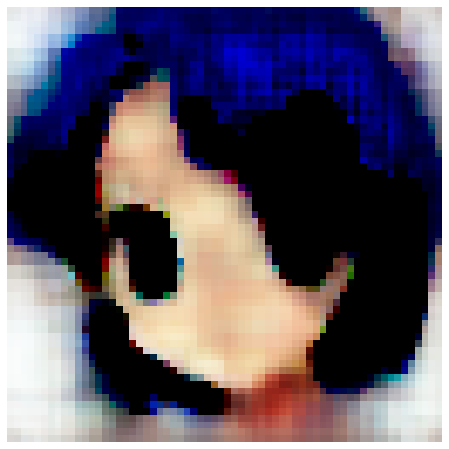

In [43]:
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
print(" ----for 50 epochs------")
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[1], padding=2).cpu(),(1,2,0)))

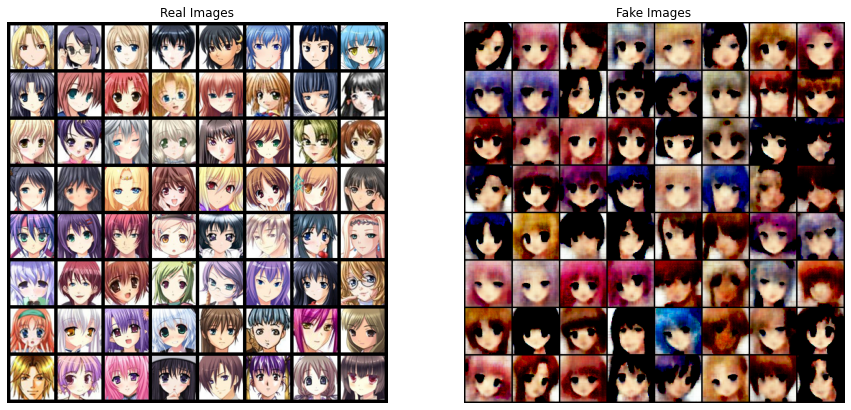

In [41]:
# Grab a batch of real images from the dataloader
real_batch= next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch[:64], padding=2).cpu(),(1,2,0)))
plt.show()

In [42]:
fake_images = decoded_batch # img_list[-1]
print(len(fake_images))
for i in range(len(fake_images)):
  save_image(unorm(fake_images[i]), fake_image_save_path+f'fake_image_{i}.jpeg')

128
